# Fine-Tuning Text-to-Image - DIY

***
In this DIY notebook, you learn how to fine-tune the Stable Diffusion model for your dataset. This can be useful when creating art, logos, custom designs, NFTs, or fun stuff such as generating custom artificial intelligence (AI) images of your pets or avatars of yourself.


Model license: By using this model, you agree to the [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL).

***

1. [Setup](#1.-Setup)
2. [Fine-tune the pretrained model on a custom dataset](#2.-Fine-tune-the-pretrained-model-on-a-custom-dataset)
* 2.1 [Retrieve training artifacts](#2.1.-Retrieve-training-artifacts)
* 2.2 [Set training parameters](#2.2.-Set-training-parameters)
* 2.3 [Train with automatic model tuning](#2.3.-Train-with-automatic-model-tuning)
* 2.4 [Start training](#2.4.-Start-training)
* 2.5 [Deploy and run inference on the fine-tuned model](#2.5.-Deploy-and-run-inference-on-the-fine-tuned-model)


Note: This notebook was tested on an ml.m5.xlarge instance in Amazon SageMaker Studio with the Python 3 (Data Science) kernel, and in a SageMaker notebook instance with the conda_python3 kernel.

### 1. Setup

***

Before running the notebook, some initial steps are required for setup. This notebook requires ipywidgets and the latest version of SageMaker.


***

#### Permissions and environment variables

***
To host on SageMaker, we must set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access.

***

In [2]:
#Install matplotlib library
!pip install matplotlib

# Import python libraries
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name

# Get the correct Amazon S3 bucket name.
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

s3 = boto3.resource('s3')

# Get the name of the S3 bucket with the prefix, lab-code.
for bucket in s3.buckets.all():
    if bucket.name.startswith('lab-code'):
        mybucket = bucket.name
        print(mybucket)
sess = sagemaker.Session(default_bucket = mybucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
lab-code-50d328e0


## 2. Fine-tune the pretrained model on a custom dataset

---
Previously, you saw how to run inference on a pretrained model. Next, you explore how a model can be fine-tuned to a custom dataset with any number of classes.

The model can be fine-tuned to any dataset of images. It works very well, even with as few as five training images.

The fine-tuning script is built on the script from [DreamBooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. The following instructions describe how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images can be of `.png` or `.jpg` or `.jpeg` format.
  - The `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you can choose to ignore 'class_prompt'.
  - The `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present, or not enough images are already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The S3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt, and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on. For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. Prior preservation tries to avoid overfitting by showing images of different dogs while training for a particular dog. A tag, indicating the specific dog present in instance prompt, is missing in the class prompt. For instance, the instance prompt might be "a photo of a Doppler dog" and the class prompt might be "a photo of a dog". You can enable prior preservation by setting the hyperparameter with_prior_preservation = True.



We provide a default dataset of dog images. It consists of images (instance images corresponding to an instance prompt) of a single dog with no class images. If using the default dataset, try the prompt "a photo of a Doppler dog" while doing inference in the demo notebook.


License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 2.1. Retrieve training artifacts

---
Here, we retrieve the training Docker container, the training algorithm source, and the pretrained base model. Note that model_version="*" fetches the latest model.

---

In [3]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the Stable Diffusion models support fine-tuning. Therefore, we manually select a model
# that supports fine-tuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "1.*",
    "training",
)

# Define the training instance type.
training_instance_type = "ml.p3.2xlarge"

# Retrieve the Docker image.
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files, including data processing, model training, and so on.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pretrained model tarball to further fine-tune.
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'model-txt2img-stabilityai-stable-diffusion-v2-1-base' with wildcard version identifier '1.*'. You can pin to version '1.1.3' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


### 2.2. Set training parameters

---
Now that we have finished the required setup, we are ready to train our Stable Diffusion model. To begin, let's create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.

Two sets of parameters need to be set for training. The first set includes the parameters for the training job. 
- *Training data path:* This is the S3 folder in which the input data is stored.
- *Training output path:* This the S3 folder in which the training output is stored.
- *Training instance type:* This indicates the type of machine on which to run the training. We previously defined the training instance type to fetch the correct train_image_uri.

The second set of parameters include algorithm-specific training hyperparameters.

---

In [4]:
# Sample training data is available in this S3 bucket.
training_data_bucket = mybucket
training_data_prefix = "training_data/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
print(s3_output_location)

s3://lab-code-50d328e0/training/output


---
For algorithm-specific hyperparameters, we start by fetching the Python dictionary of training hyperparameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [5]:
from sagemaker import hyperparameters

# Retrieve the default hyperparameters for fine-tuning the model.
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values.
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'compute_fid': 'False', 'seed': '0'}


---
If setting `with_prior_preservation=True`, use the ml.g5.2xlarge instance type because more memory is required to generate class images. Currently, training on the ml.g4dn.2xlarge instance type runs into a CUDA out of memory issue when setting `with_prior_preservation=True`.

---

### 2.3. Train with automatic model tuning
---

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We use a HyperparameterTuner object to interact with SageMaker hyperparameter tuning APIs. Here, we tune two hyperparameters: `learning_rate` and `max_steps`.

---

In [6]:
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner


use_amt = True

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-7, 3e-6, "Linear"),
    "max_steps": IntegerParameter(50, 400, "Linear"),
}

### 2.4. Start training
---

We start by creating the estimator object with all the required assets. Then we launch the training job.

Note: The code run might take up to 15 minutes to be completed.

---

In [7]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"diy-model-{train_model_id}-transfer-learning")

# Create a SageMaker estimator instance.
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)


if use_amt:
    # Let the estimator emit fid_score metric to AMT.
    sd_estimator.set_hyperparameters(compute_fid="True")
    tuner_parameters = {
        "estimator": sd_estimator,
        "metric_definitions": [{"Name": "fid_score", "Regex": "fid_score=([-+]?\\d\\.?\\d*)"}],
        "objective_metric_name": "fid_score",
        "objective_type": "Minimize",
        "hyperparameter_ranges": hyperparameter_ranges,
        "max_jobs": 1,
        "max_parallel_jobs": 1,
        "strategy": "Bayesian",
        "base_tuning_job_name": training_job_name,
    }

    tuner = HyperparameterTuner(**tuner_parameters)
    tuner.fit({"training": training_dataset_s3_path}, logs=True)
else:
    # Launch a SageMaker training job by passing s3 path of the training data.
    sd_estimator.fit({"training": training_dataset_s3_path}, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................!


If you set `max_jobs=9` and `max_parallel_jobs=3` above, it takes around 60 mins on the default dataset when using automatic model tuning. If more quota for the training instance type is available, increase the `max_parallel_jobs` to speed up the tuning.

### 2.5. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the SageMaker JumpStart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

Note: The code run might take up to 15 minutes to be completed.

---

In [8]:
inference_instance_type = "ml.g4dn.2xlarge"

# Retrieve the inference Docker container URI.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

endpoint_name = name_from_base(f"diy-endpoint-")
model_name = name_from_base(f"diy-model-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint.
finetuned_predictor = (tuner if use_amt else sd_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    image_uri=deploy_image_uri,
    endpoint_name=endpoint_name,
    model_name=model_name,
)


2024-08-11 16:42:52 Starting - Starting the training job
2024-08-11 16:42:52 Pending - Preparing the instances for training
2024-08-11 16:42:52 Downloading - Downloading the training image
2024-08-11 16:42:52 Training - Training image download completed. Training in progress.
2024-08-11 16:42:52 Uploading - Uploading generated training model
2024-08-11 16:42:52 Completed - Resource retained for reuse
-----------!

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

Next, we query the fine-tuned model, parse the response, and display the generated image.

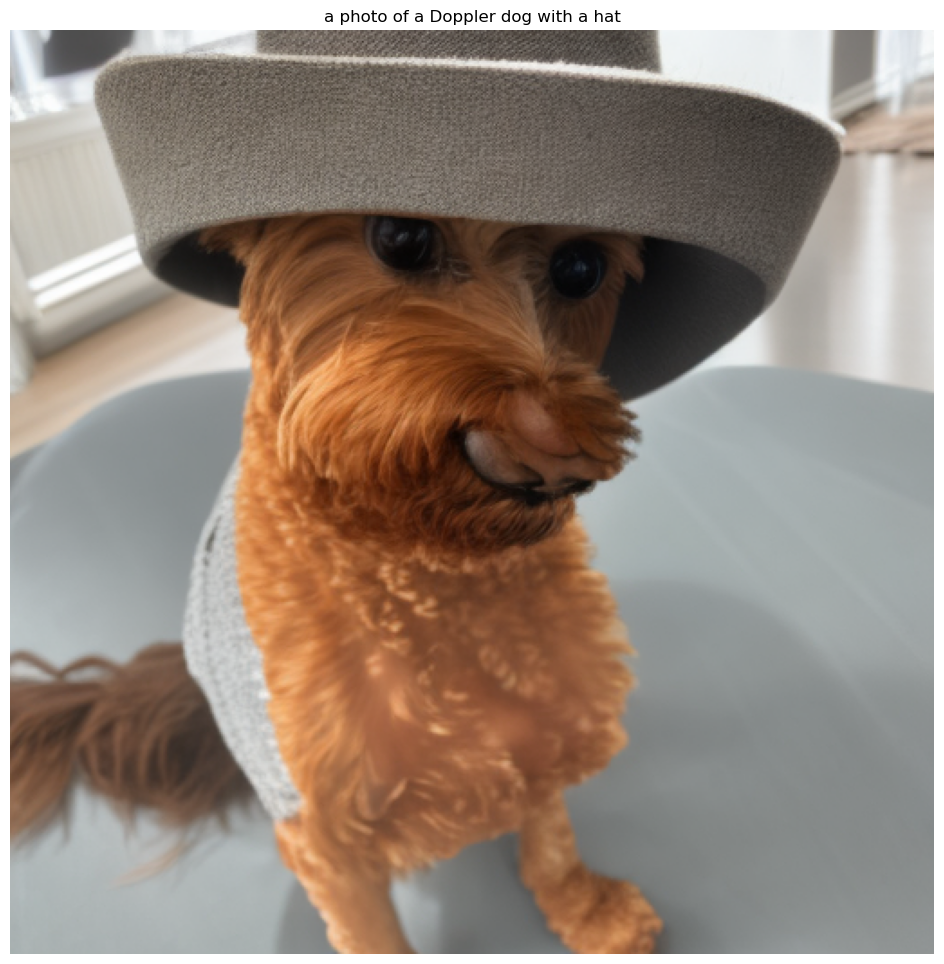

In [10]:
text = "a photo of a Doppler dog with a hat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)